In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [3]:
address = 'Red Square, Russia'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
moscow_center = (latitude, longitude)
print('The geograpical coordinate of Red Square in Moscow are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Red Square in Moscow are 55.7536532, 37.6213676671642.


In [4]:
moscow_center

(55.7536532, 37.6213676671642)

In [5]:
!pip install shapely
import shapely.geometry

!pip install pyproj
import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('Moscow center longitude={}, latitude={}'.format(latitude, longitude))
x, y = lonlat_to_xy(latitude, longitude)
print('Moscow center UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('Moscow center longitude={}, latitude={}'.format(lo, la))

     |████████████████████████████████| 1.5MB 5.3MB/s eta 0:00:01
     |████████████████████████████████| 11.2MB 5.3MB/s eta 0:00:01
Coordinate transformation check
-------------------------------
Moscow center longitude=55.7536532, latitude=37.6213676671642
Moscow center UTM X=4153902.7782251323, Y=5041735.95554852
Moscow center longitude=55.7536532, latitude=37.62136766716419


In [6]:
moscow_center_x, moscow_center_y = lonlat_to_xy(longitude, latitude) # City center in Cartesian coordinates

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = moscow_center_x - 6000
x_step = 600
y_min = moscow_center_y - 6000 - (int(21/k)*k*600 - 12000)/2
y_step = 600 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = 300 if i%2==0 else 0
    for j in range(0, 21):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(moscow_center_x, moscow_center_y, x, y)
        if (distance_from_center <= 6001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighborhood centers generated.')

364 candidate neighborhood centers generated.


In [7]:
type(latitudes)

list

In [8]:
!pip install folium

import folium

     |████████████████████████████████| 92kB 4.7MB/s eta 0:00:01


In [9]:
#map_moscow = folium.Map(location=moscow_center, zoom_start=13)
#folium.Marker(moscow_center, popup='Red Square').add_to(map_moscow)
#for lat, lon in zip(latitudes, longitudes):
#    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_moscow) 
#    folium.Circle([lat, lon], radius=300, color='blue', fill=False).add_to(map_moscow)
   # folium.Marker([lat, lon]).add_to(map_moscow)
#map_moscow

In [10]:
type(latitudes)

list

In [11]:
# @hidden_cell
def get_address(latitude, longitude):
    try:
        url = 'https://geocode-maps.yandex.ru/1.x/?apikey=9ec35103-522b-43b2-86af-e8c4fe2c46e8&format=json&geocode={},{}&lang=en-US'.format(longitude,latitude)
        response = requests.get(url).json()
        results = response['response']
        address = response['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['metaDataProperty']['GeocoderMetaData']['AddressDetails']['Country']['AddressLine']
        return address
    except:
        return None



In [12]:
addr = get_address(moscow_center[0], moscow_center[1])
print('Reverse geocoding check')
print('-----------------------')
print('Address of [{}, {}] is: {}'.format(moscow_center[0], moscow_center[1], addr))

Reverse geocoding check
-----------------------
Address of [55.7536532, 37.6213676671642] is: Russia, Moscow, Red Square


In [13]:
addr

'Russia, Moscow, Red Square'

In [14]:
print('Obtaining location addresses: ', end='')
addresses = []
for lat, lon in zip(latitudes, longitudes):
    address = get_address(lat, lon)
    if address is None:
        address = 'NO ADDRESS'
    address = address.replace(', Russia', '') # We don't need country part of address
    addresses.append(address)
    print(' .', end='')
print(' done.')

Obtaining location addresses:  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


In [15]:
addresses[150:170]

['Russia, Moscow, Sibirsky Drive, 2с9',
 'Russia, Moscow, Kalitnikovskoye Cemetery',
 'Russia, Moscow, Yugo-Vostochniy Administrative Okrug, Nizhegorodskiy District',
 'Russia, Moscow, Strelbischensky Lane, 25Ас2',
 'Russia, Moscow, Tsentralniy Administrative Okrug, Presnenskiy District',
 'Russia, Moscow, Tsentralniy Administrative Okrug, Presnenskiy District, Residential Complex Lucky',
 'Russia, Moscow, Sredny Tryokhgorny Lane, 7',
 'Russia, Moscow, Kapranova Lane, 4',
 'Russia, Moscow, Novinsky Boulevard, 21',
 'Russia, Moscow, Malaya Molchanovka Street, 8',
 'Russia, Moscow, Vozdvizhenka Street',
 'Russia, Moscow, Mokhovaya Street',
 'Russia, Moscow, Tsentralniy Administrative Okrug, Tverskoy District',
 'Russia, Moscow, Sadovnicheskaya Street, 8',
 'Russia, Moscow, Sadovnicheskaya Street, 29',
 'Russia, Moscow, 1st Kotelnichesky Lane',
 'Russia, Moscow, Verkhnyaya Radischevskaya Street',
 "Russia, Moscow, N. Pryamikov Children's Park",
 'Russia, Moscow, Taganskaya Street, 58с12',

In [16]:
import pandas as pd

df_locations = pd.DataFrame({'Address': addresses,
                             'Latitude': latitudes,
                             'Longitude': longitudes,
                             'X': xs,
                             'Y': ys,
                             'Distance from center': distances_from_center})

df_locations.tail()

,Address,Latitude,Longitude,X,Y,Distance from center
359,"Russia, Moscow, Grafsky Lane, 14к1",55.802769,37.641535,1.904855e+06,6.418695e+06,5747.173218
360,"Russia, Moscow, Severo-Vostochniy Administrati...",55.801052,37.650368,1.905455e+06,6.418695e+06,5715.767665
361,"Russia, Moscow, Sokolniki Park",55.799335,37.659200,1.906055e+06,6.418695e+06,5747.173218
362,"Russia, Moscow, 2nd Luchevoy Glade",55.797617,37.668031,1.906655e+06,6.418695e+06,5840.376700
363,"Russia, Moscow, 6th Luchevoy Glade",55.795898,37.676861,1.907255e+06,6.418695e+06,5992.495307


In [17]:
df_locations['Distance from center'].describe()

count     364.000000
mean     4007.610159
std      1419.442075
min       300.000000
25%      2954.657341
50%      4242.627429
75%      5204.805472
max      5992.495307
Name: Distance from center, dtype: float64

In [18]:
df_locations['X'][0]

1903655.3526300967

In [19]:
df_locations.to_pickle('./locations.pkl')

In [20]:
df_locations.to_csv("/home/dsxuser/work/df_locations.csv")

In [149]:
 # @hidden_cell
import dropbox
access_token = 'eJrsoCmn-fQAAAAAAAM1bglaQWNO5L81gGXBQILQvSB0Uzh6Xg404BfUPn4laR2c'
file_from = '/home/dsxuser/work/df_locations.csv' # //local file path
file_to = '/df_locations.csv'     # // dropbox path
def upload_file(file_from, file_to):
    dbx = dropbox.Dropbox(access_token)
    f = open(file_from, 'rb')
    dbx.files_upload(f.read(), file_to)
upload_file(file_from,file_to)

## Now focus on cafes!

In [21]:
#url = 'https://drive.google.com/open?id=1FVI_BFF3-KbGq5Tkg_CrH6TRj9khmnvC'
!wget -q -O 'data.json' https://www.dropbox.com/s/05riyy94ds99sor/restaurantsUTF.txt?dl=0
print('Data downloaded!')

Data downloaded!


In [22]:
with open('data.json', 'r', encoding='utf-8-sig') as json_data:
    data = json.load(json_data)

In [23]:
df = pd.DataFrame.from_dict(data, orient='columns')

In [24]:
df.head(5)

,Address,AdmArea,District,ID,IsNetObject,Latitude_WGS84,Longitude_WGS84,Name,OperatingCompany,PublicPhone,SeatsCount,SocialPrivileges,TypeObject,geoData,global_id
0,"город Москва, улица Егора Абакумова, дом 9",Северо-Восточный административный округ,Ярославский район,00151635,нет,55.8790015313033730,37.7145650004360390,СМЕТАНА,NaN,[{'PublicPhone': '(499) 183-14-10'}],48,нет,кафе,"{'type': 'Point', 'coordinates': [37.714565000...",637376221
1,"город Москва, улица Талалихина, дом 2/1, корпус 1",Центральный административный округ,Таганский район,000077874,нет,55.7382386551547000,37.6733061300344000,Родник,NaN,[{'PublicPhone': '(495) 676-55-35'}],35,нет,кафе,"{'type': 'Point', 'coordinates': [37.673306130...",637376331
2,"город Москва, Абельмановская улица, дом 6",Центральный административный округ,Таганский район,000024309,нет,55.7355114718314000,37.6696475969381000,Кафе «Академия»,NaN,[{'PublicPhone': '(495) 662-30-10'}],95,нет,кафе,"{'type': 'Point', 'coordinates': [37.669647596...",637376349
3,"город Москва, Абрамцевская улица, дом 1",Северо-Восточный административный округ,район Лианозово,000021894,да,55.8919565397311000,37.5733294712098000,ПИЦЦЕТОРИЯ,Пиццетория,[{'PublicPhone': '(499) 200-17-09'}],40,нет,кафе,"{'type': 'Point', 'coordinates': [37.573329471...",637376381
4,"город Москва, Абрамцевская улица, дом 9, корпус 1",Северо-Восточный административный округ,район Лианозово,00119365,нет,55.9040863698490400,37.5723061316711200,Кафе «Вишневая метель»,NaN,[{'PublicPhone': '(499) 200-00-22'}],50,нет,кафе,"{'type': 'Point', 'coordinates': [37.572306131...",637376403


In [25]:
df_type = df.pivot_table(index=['TypeObject'], aggfunc='size')
df_type.sort_values(ascending = False)

TypeObject
кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
dtype: int64

In [26]:
df1 = df[['Name','Address','District', 'AdmArea','TypeObject','Latitude_WGS84','Longitude_WGS84']]

In [27]:
df1_type = df1.pivot_table(index=['District'], aggfunc='size')
df1_type.sort_values(ascending = False).head(20)

District
Тверской район              769
Пресненский район           719
Басманный район             633
Даниловский район           466
район Замоскворечье         389
район Хамовники             374
Таганский район             356
Мещанский район             351
район Арбат                 271
Хорошёвский район           258
Красносельский район        229
район Раменки               209
район Марьино               206
район Марьина Роща          194
район Якиманка              193
район Митино                179
район Тропарёво-Никулино    177
район Соколиная Гора        176
район Нагатино-Садовники    174
район Дорогомилово          169
dtype: int64

In [28]:
indexCafe = df1[df1['TypeObject'] =="столовая"].index

In [29]:
indexCafe1 = df1[df1['TypeObject'] =="предприятие быстрого обслуживания"].index

In [30]:
indexCafe2 = df1[df1['TypeObject'] =="бар"].index

In [31]:
indexCafe3 = df1[df1['TypeObject'] =="буфет"].index

In [32]:
indexCafe4 = df1[df1['TypeObject'] =="кафетерий"].index

In [33]:
indexCafe5 = df1[df1['TypeObject'] =="закусочная"].index

In [34]:
indexCafe6 = df1[df1['TypeObject'] =="магазин (отдел кулинарии)"].index

In [35]:
df1.drop(indexCafe, inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [36]:
df1.drop(indexCafe1, inplace=True)

In [37]:
df1.drop(indexCafe2, inplace=True)

In [38]:
df1.drop(indexCafe3, inplace=True)

In [39]:
df1.drop(indexCafe4, inplace=True)

In [40]:
df1.drop(indexCafe5, inplace=True)

In [41]:
df1.drop(indexCafe6, inplace=True)

In [42]:
df1.reset_index(drop=True, inplace=True)

In [43]:
df1.head()

,Name,Address,District,AdmArea,TypeObject,Latitude_WGS84,Longitude_WGS84
0,СМЕТАНА,"город Москва, улица Егора Абакумова, дом 9",Ярославский район,Северо-Восточный административный округ,кафе,55.8790015313033730,37.7145650004360390
1,Родник,"город Москва, улица Талалихина, дом 2/1, корпус 1",Таганский район,Центральный административный округ,кафе,55.7382386551547000,37.6733061300344000
2,Кафе «Академия»,"город Москва, Абельмановская улица, дом 6",Таганский район,Центральный административный округ,кафе,55.7355114718314000,37.6696475969381000
3,ПИЦЦЕТОРИЯ,"город Москва, Абрамцевская улица, дом 1",район Лианозово,Северо-Восточный административный округ,кафе,55.8919565397311000,37.5733294712098000
4,Кафе «Вишневая метель»,"город Москва, Абрамцевская улица, дом 9, корпус 1",район Лианозово,Северо-Восточный административный округ,кафе,55.9040863698490400,37.5723061316711200


In [44]:
print('The dataframe has {} unique restaurants and cafes out of {} total'.format(
        len(df1['Name'].unique()),
        df1.shape[0]
    )
)

The dataframe has 6202 unique restaurants and cafes out of 8384 total


In [45]:
df_type2 = df1.pivot_table(index=['District'], aggfunc='size')
df_type2.sort_values(ascending = False).head(20)

District
Тверской район              578
Пресненский район           575
Басманный район             436
район Замоскворечье         278
Даниловский район           274
Мещанский район             259
район Хамовники             249
район Арбат                 212
Таганский район             212
Хорошёвский район           184
Красносельский район        140
район Якиманка              131
район Дорогомилово          119
район Раменки               118
Донской район               110
поселение Сосенское         103
район Марьина Роща          102
район Тропарёво-Никулино     99
Обручевский район            95
район Филёвский Парк         89
dtype: int64

In [46]:
print(df1.dtypes) #check type

Name               object
Address            object
District           object
AdmArea            object
TypeObject         object
Latitude_WGS84     object
Longitude_WGS84    object
dtype: object


In [47]:
# change coordinates type to float
df1[['Latitude_WGS84','Longitude_WGS84']] = df1[['Latitude_WGS84','Longitude_WGS84']].astype("float")

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [48]:
z1 = df1['Latitude_WGS84'].tolist()
z2 = df1['Longitude_WGS84'].tolist()


In [49]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

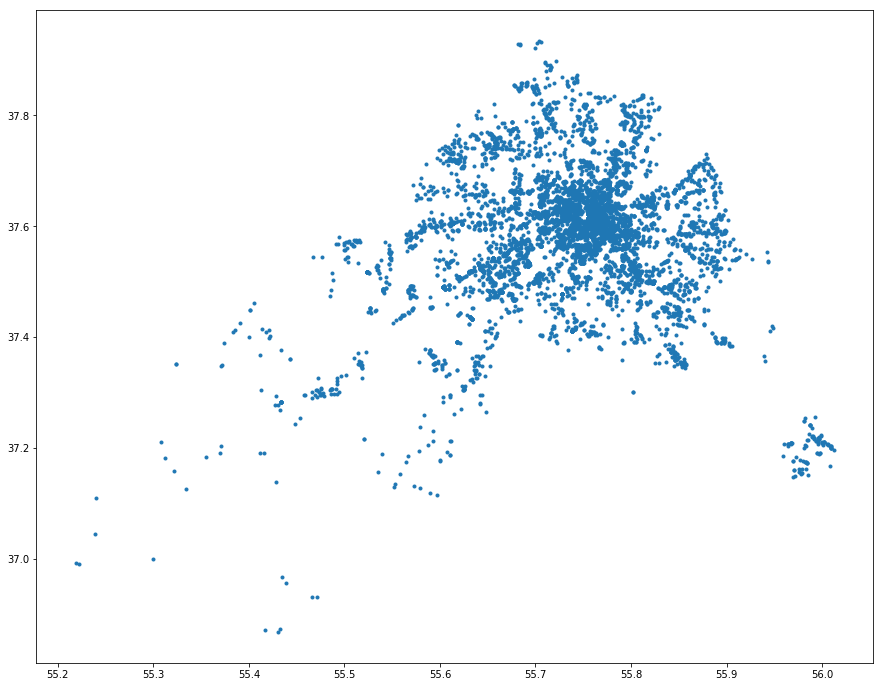

In [50]:
plt.figure(figsize=(15, 12))
plt.scatter(z1, z2, marker='.')


### Excluding places outside of center

Calculate distance to Red Square from each place

In [51]:
moscow_center_x, moscow_center_y = lonlat_to_xy(37.6213676671642, 55.7536532)

In [52]:
moscow_center_x, moscow_center_y

(1905455.3526300967, 6412979.504109485)

In [53]:
converted_Xs = []
converted_Ys = []
distances_from_center1 = []
df2 =[]
df3= []
j = 0
i = 0

In [54]:
 for j in range (0, len(df1['Name'])):
        convert_to_x, convert_to_y = lonlat_to_xy(df1['Longitude_WGS84'][j], df1['Latitude_WGS84'][j])
        converted_Xs.append(convert_to_x)
        converted_Ys.append(convert_to_y)
        

In [55]:
for i in range (0, len(df1['Name'])):
                distance_from_center = calc_xy_distance(moscow_center_x, moscow_center_y, converted_Xs[i],converted_Ys[i])
                distances_from_center1.append(distance_from_center)


In [56]:
#df3 = pd.DataFrame({'Distance': distances_from_center1}, {'Xs' : converted_Xs}, {'Ys' : converted_Ys})

In [57]:
df3_1 = pd.DataFrame({'Xs' : converted_Xs})

In [58]:
df3_2 = pd.DataFrame({'Ys' : converted_Ys})

In [59]:
df3_3 = pd.DataFrame({'Distance': distances_from_center1})

In [60]:
df3 = pd.concat([df3_1, df3_2, df3_3], axis=1, sort=False)

In [61]:
df2 = pd.concat([df1, df3], axis=1, sort=False)

In [62]:
df2.head()

,Name,Address,District,AdmArea,TypeObject,Latitude_WGS84,Longitude_WGS84,Xs,Ys,Distance
0,СМЕТАНА,"город Москва, улица Егора Абакумова, дом 9",Ярославский район,Северо-Восточный административный округ,кафе,55.879002,37.714565,1.906443e+06,6.428440e+06,15491.733029
1,Родник,"город Москва, улица Талалихина, дом 2/1, корпус 1",Таганский район,Центральный административный округ,кафе,55.738239,37.673306,1.909186e+06,6.412407e+06,3774.143090
2,Кафе «Академия»,"город Москва, Абельмановская улица, дом 6",Таганский район,Центральный административный округ,кафе,55.735511,37.669648,1.909065e+06,6.412036e+06,3730.678687
3,ПИЦЦЕТОРИЯ,"город Москва, Абрамцевская улица, дом 1",район Лианозово,Северо-Восточный административный округ,кафе,55.891957,37.573329,1.897408e+06,6.426881e+06,16063.160638
4,Кафе «Вишневая метель»,"город Москва, Абрамцевская улица, дом 9, корпус 1",район Лианозово,Северо-Восточный административный округ,кафе,55.904086,37.572306,1.896896e+06,6.428167e+06,17433.627777


In [63]:
df2['Distance'].describe()

count     8384.000000
mean      9054.580604
std       8023.745764
min        115.328903
25%       3147.044106
50%       6874.416501
75%      13056.849629
max      73212.903362
Name: Distance, dtype: float64

In [64]:
indexDistance = df2[df2['Distance'] >=6000].index

In [65]:
df2.drop(indexDistance, inplace=True)

In [66]:
df2.reset_index(drop=True).head()

,Name,Address,District,AdmArea,TypeObject,Latitude_WGS84,Longitude_WGS84,Xs,Ys,Distance
0,Родник,"город Москва, улица Талалихина, дом 2/1, корпус 1",Таганский район,Центральный административный округ,кафе,55.738239,37.673306,1.909186e+06,6.412407e+06,3774.143090
1,Кафе «Академия»,"город Москва, Абельмановская улица, дом 6",Таганский район,Центральный административный округ,кафе,55.735511,37.669648,1.909065e+06,6.412036e+06,3730.678687
2,Брусника,"город Москва, переулок Сивцев Вражек, дом 6/2",район Арбат,Центральный административный округ,кафе,55.747390,37.598128,1.904275e+06,6.411818e+06,1656.012860
3,Американская Лаборатория Десертов,"город Москва, Филипповский переулок, дом 15/5",район Арбат,Центральный административный округ,кафе,55.750591,37.598354,1.904170e+06,6.412168e+06,1520.246004
4,Месопотамия,"город Москва, улица Арбат, дом 4, строение 1",район Арбат,Центральный административный округ,ресторан,55.752016,37.598455,1.904123e+06,6.412323e+06,1484.816212


In [67]:
df2['Distance'].describe() #double-check 

count    3892.000000
mean     3096.980473
std      1514.336848
min       115.328903
25%      1810.198424
50%      2951.718050
75%      4322.994038
max      5994.664168
Name: Distance, dtype: float64

In [68]:
Lat_list = df2['Latitude_WGS84'].tolist()
Lon_list = df2['Longitude_WGS84'].tolist()

In [69]:
#map_moscow1 = folium.Map(location=moscow_center, zoom_start=13)
#folium.Marker(moscow_center, popup='Red Square', parse_html=True).add_to(map_moscow)

#for lat, lon in zip(latitudes, longitudes):
#    folium.Circle([lat, lon], radius=300, color='red', fill=False).add_to(map_moscow1)

#for lat1, lon1 in zip(Lat_list, Lon_list):
#    folium.Circle([lat1, lon1], radius=1, color='blue', fill=False).add_to(map_moscow1) 

#map_moscow1


##### Cleansing of data

In [70]:
print('The dataframe has {} unique names out of {} total number of places'.format(
        len(df2['Name'].unique()),
        df2.shape[0]
    )
)

The dataframe has 3158 unique names out of 3892 total number of places


In [71]:
df2['Name'].value_counts(dropna=False).head(20)

Шоколадница        74
Кафе               28
Хлеб насущный      21
Starbucks          19
Чайхона №1         19
Кофе Хаус          19
KFC                18
Хинкальная         18
Прайм стар         17
Бургер Кинг        13
Домино'с Пицца     11
Иль Патио          10
ШОКОЛАДНИЦА         9
Кофемания           9
Теремок             9
Старбакс            9
Крошка Картошка     9
Ваби-Саби           9
Вареничная №1       9
Грабли              8
Name: Name, dtype: int64

In [72]:
test = df2


In [73]:
# %load https://raw.githubusercontent.com/petro1eum/capstone/master/CleaningData(1).py


# In[1]:


test.loc[test['Name'].str.contains('Шоколадница'), 'Name'] = 'Шоколадница'
test.loc[test['Name'].str.contains('ШОКОЛАДНИЦА'), 'Name'] = 'Шоколадница'
test.loc[test['Name'].str.contains('Хлеб насущный'), 'Name'] = 'Хлеб насущный'
test.loc[test['Name'].str.contains('Хлеб Насущный'), 'Name'] = 'Хлеб насущный'
test.loc[test['Name'].str.contains('ХЛЕБ НАСУЩНЫЙ'), 'Name'] = 'Хлеб насущный'
test.loc[test['Name'].str.contains('Starbucks'), 'Name'] = 'Starbucks'
test.loc[test['Name'].str.contains('Старбак'), 'Name'] = 'Starbucks'
test.loc[test['Name'].str.contains('Чайхона №1'), 'Name'] = 'Чайхона №1'
test.loc[test['Name'].str.contains('Кофе Хаус'), 'Name'] = 'Кофе Хаус'
test.loc[test['Name'].str.contains('КОФЕ ХАУС'), 'Name'] = 'Кофе Хаус'
test.loc[test['Name'].str.contains('KFC'), 'Name'] = 'KFC'
test.loc[test['Name'].str.contains('КФС'), 'Name'] = 'KFC'
test.loc[test['Name'].str.contains('Прайм'), 'Name'] = 'Прайм стар'
test.loc[test['Name'].str.contains('ПРАЙМ'), 'Name'] = 'Прайм стар'
test.loc[test['Name'].str.contains('PRIME'), 'Name'] = 'Прайм стар'
test.loc[test['Name'].str.contains('Бургер Кинг'), 'Name'] = 'Burger King'
test.loc[test['Name'].str.contains('Domino'), 'Name'] = 'Dominos Pizza'
test.loc[test['Name'].str.contains('Домино'), 'Name'] = 'Dominos Pizza'
test.loc[test['Name'].str.contains('Караваевы'), 'Name'] = 'Кулинарная лавка братьев Караваевых'
test.loc[test['Name'].str.contains('Патио'), 'Name'] = 'Il Patio'
test.loc[test['Name'].str.contains('Патио'), 'Name'] = 'Il Patio'
test.loc[test['Name'].str.contains('PATIO'), 'Name'] = 'Il Patio'
test.loc[test['Name'].str.contains('МУ-МУ'), 'Name'] = 'Му-Му'
test.loc[test['Name'].str.contains('Му-Му'), 'Name'] = 'Му-Му'
test.loc[test['Name'].str.contains('Му Му'), 'Name'] = 'Му-Му'
test.loc[test['Name'].str.contains('МУ МУ'), 'Name'] = 'Му-Му'
test.loc[test['Name'].str.contains('ТЕРЕМОК'), 'Name'] = 'Теремок'
test.loc[test['Name'].str.contains('Крошка картошка'), 'Name'] = 'Крошка Картошка'
test.loc[test['Name'].str.contains('КРОШКА КАРТОШКА'), 'Name'] = 'Крошка Картошка'
test.loc[test['Name'].str.contains('Макд'), 'Name'] = 'Макдоналдс'
test.loc[test['Name'].str.contains('donald'), 'Name'] = 'Макдоналдс'
test.loc[test['Name'].str.contains('ДОНАЛ'), 'Name'] = 'Макдоналдс'
test.loc[test['Name'].str.contains('донал'), 'Name'] = 'Макдоналдс'
test.loc[test['Name'].str.contains('Азбука Вкуса'), 'Name'] = 'Азбука вкуса'
test.loc[test['Name'].str.contains('Дабл Би'), 'Name'] = 'Даблби'
test.loc[test['Name'].str.contains('Даблби'), 'Name'] = 'Даблби'
test.loc[test['Name'].str.contains('Дабл би'), 'Name'] = 'Даблби'
test.loc[test['Name'].str.contains('Кафе Хинкальная'), 'Name'] = 'Кафе «Хинкальная»'
test.loc[test['Name'].str.contains('Планета Суши'), 'Name'] = 'Планета суши'
test.loc[test['Name'].str.contains('Планета суши'), 'Name'] = 'Планета суши'
test.loc[test['Name'].str.contains('ПЛАНЕТА СУШИ'), 'Name'] = 'Планета суши'
test.loc[test['Name'].str.contains('Якитория'), 'Name'] = 'Якитория'
test.loc[test['Name'].str.contains('ЯКИТОРИЯ'), 'Name'] = 'Якитория'
test.loc[test['Name'].str.contains('КОРЧМА ТАРАС БУЛЬБА'), 'Name'] = 'Корчма Тарас Бульба'
test.loc[test['Name'].str.contains('чма Тарас'), 'Name'] = 'Корчма Тарас Бульба'
test.loc[test['Name'].str.contains('Бульба'), 'Name'] = 'Корчма Тарас Бульба'
test.loc[test['Name'].str.contains('КОФЕМАНИЯ'), 'Name'] = 'Кофемания'
test.loc[test['Name'].str.contains('Goodman'), 'Name'] = 'Goodman'
test.loc[test['Name'].str.contains('GOODMAN'), 'Name'] = 'Goodman'
test.loc[test['Name'].str.contains('Гудман'), 'Name'] = 'Goodman'
test.loc[test['Name'].str.contains('ДВЕ ПАЛОЧКИ'), 'Name'] = 'Две палочки'
test.loc[test['Name'].str.contains('BBBurgers'), 'Name'] = 'BB&Burgers'
test.loc[test['Name'].str.contains('В&В'), 'Name'] = 'BB&Burgers'
test.loc[test['Name'].str.contains('BB'), 'Name'] = 'BB&Burgers'
test.loc[test['Name'].str.contains('ББ и Бургерс'), 'Name'] = 'BB&Burgers'
test.loc[test['Name'].str.contains('Папа Джонс'), 'Name'] = 'Папа Джонс'
test.loc[test['Name'].str.contains('Бизон'), 'Name'] = 'Стейкхаус "Бизон"'
test.loc[test['Name'].str.contains('Frayda'), 'Name'] = 'TGI Fraydas'
test.loc[test['Name'].str.contains('АКАДЕМИЯ'), 'Name'] = 'Пиццерия "Академия"'
test.loc[test['Name'].str.contains('Академия'), 'Name'] = 'Пиццерия "Академия"'
test.loc[test['Name'].str.contains('БУТЧЕР'), 'Name'] = 'Бутчер'
test.loc[test['Name'].str.contains('Сабвей'), 'Name'] = 'Subway'



In [74]:
test['Name'].value_counts(dropna=False).head(30)

Шоколадница                            93
Прайм стар                             59
Starbucks                              38
Хлеб насущный                          30
Кафе                                   28
Кофе Хаус                              25
Чайхона №1                             22
KFC                                    21
Il Patio                               20
Даблби                                 19
Хинкальная                             18
Кулинарная лавка братьев Караваевых    15
Burger King                            15
Му-Му                                  14
Dominos Pizza                          13
Якитория                               12
Азбука вкуса                           12
Кофемания                              11
BB&Burgers                             11
Папа Джонс                             11
Макдоналдс                             11
Крошка Картошка                        10
Теремок                                10
Ваби-Саби                         

In [75]:
test.reset_index(drop=True).head()

,Name,Address,District,AdmArea,TypeObject,Latitude_WGS84,Longitude_WGS84,Xs,Ys,Distance
0,Родник,"город Москва, улица Талалихина, дом 2/1, корпус 1",Таганский район,Центральный административный округ,кафе,55.738239,37.673306,1.909186e+06,6.412407e+06,3774.143090
1,"Пиццерия ""Академия""","город Москва, Абельмановская улица, дом 6",Таганский район,Центральный административный округ,кафе,55.735511,37.669648,1.909065e+06,6.412036e+06,3730.678687
2,Брусника,"город Москва, переулок Сивцев Вражек, дом 6/2",район Арбат,Центральный административный округ,кафе,55.747390,37.598128,1.904275e+06,6.411818e+06,1656.012860
3,Американская Лаборатория Десертов,"город Москва, Филипповский переулок, дом 15/5",район Арбат,Центральный административный округ,кафе,55.750591,37.598354,1.904170e+06,6.412168e+06,1520.246004
4,Месопотамия,"город Москва, улица Арбат, дом 4, строение 1",район Арбат,Центральный административный округ,ресторан,55.752016,37.598455,1.904123e+06,6.412323e+06,1484.816212


In [76]:
test.to_csv("/home/dsxuser/work/df_cafe.csv")

In [150]:
# @hidden_cell
import dropbox
access_token = 'eJrsoCmn-fQAAAAAAAM1bglaQWNO5L81gGXBQILQvSB0Uzh6Xg404BfUPn4laR2c'
file_from = '/home/dsxuser/work/df_cafe.csv' # //local file path
file_to = '/df_cafe.csv'     # // dropbox path
def upload_file(file_from, file_to):
    dbx = dropbox.Dropbox(access_token)
    f = open(file_from, 'rb')
    dbx.files_upload(f.read(), file_to)
upload_file(file_from,file_to)

#### Loading data on Moscow subway exits

In [77]:
!wget -q -O 'data_subway.json' https://www.dropbox.com/s/y75voyfnh52cboz/subwayUTF.json?dl=0
print('Data downloaded!')

Data downloaded!


In [78]:
with open('data_subway.json', 'r',  encoding='utf-8-sig') as json_data:
    data_subway = json.load(json_data)
df_subway = pd.DataFrame.from_dict(data_subway, orient='columns')


In [79]:
df_subway_type = df_subway.pivot_table(index=['NameOfStation'], aggfunc='size')
df_subway_type.sort_values(ascending = False).head()

NameOfStation
Комсомольская             15
Китай-город               15
Преображенская площадь    13
Пражская                  12
Охотный ряд               12
dtype: int64

In [80]:
df_subway1 = df_subway[['NameOfStation','Name','Latitude_WGS84','Longitude_WGS84']]
df_subway1.tail()

,NameOfStation,Name,Latitude_WGS84,Longitude_WGS84
1062,Коммунарка,"Коммунарка, вход-выход 2",55.560132,37.469832
1063,Коммунарка,"Коммунарка, вход-выход 3",55.559688,37.468834
1064,Коммунарка,"Коммунарка, вход-выход 4",55.559439,37.468212
1065,Косино,"Косино, вход-выход 1",55.702815,37.850991
1066,Косино,"Косино, вход-выход 2",55.704287,37.850426


In [81]:
#map_moscow2 = folium.Map(location=moscow_center, zoom_start=13)
#folium.Marker(moscow_center, popup='Red Square', parse_html=True).add_to(map_moscow2)

#for lat, lon in zip(latitudes, longitudes):
#    folium.Circle([lat, lon], radius=300, color='red', fill=False).add_to(map_moscow2)

#for lat1, lon1 in zip(df_subway1['Latitude_WGS84'], df_subway1['Longitude_WGS84']):
#    folium.Circle([lat1, lon1], radius=1, color='blue', fill=False).add_to(map_moscow2) 

#map_moscow2

In [82]:
converted_Xs = []
converted_Ys = []


In [83]:
 for j in range (0, len(df_subway1['Name'])):
        convert_to_x, convert_to_y = lonlat_to_xy(df_subway1['Longitude_WGS84'][j], df_subway1['Latitude_WGS84'][j])
        converted_Xs.append(convert_to_x)
        converted_Ys.append(convert_to_y)

In [84]:
df_subway_x = pd.DataFrame({'Xs' : converted_Xs})
df_subway_y = pd.DataFrame({'Ys' : converted_Ys})
df_subway2 = pd.concat([df_subway1, df_subway_x, df_subway_y], axis=1, sort=False)
df_subway2.head()

,NameOfStation,Name,Latitude_WGS84,Longitude_WGS84,Xs,Ys
0,Китай-город,"Китай-город, вход-выход 3 в северный вестибюль",55.7567672,37.6309849,1.905924e+06,6.413517e+06
1,Китай-город,"Китай-город, вход-выход 8 в северный вестибюль",55.7573154,37.6316766,1.905946e+06,6.413590e+06
2,Китай-город,"Китай-город, вход-выход 4 в северный вестибюль",55.7568819,37.6312698,1.905937e+06,6.413535e+06
3,Китай-город,"Китай-город, вход-выход 7 в северный вестибюль",55.7572362,37.6319506,1.905966e+06,6.413587e+06
4,Китай-город,"Китай-город, вход-выход 6 в южный вестибюль",55.7531976,37.6331045,1.906186e+06,6.413176e+06


In [85]:
df_subway2.to_csv("/home/dsxuser/work/df_subway2.csv")

In [151]:
import dropbox
access_token = 'eJrsoCmn-fQAAAAAAAM1bglaQWNO5L81gGXBQILQvSB0Uzh6Xg404BfUPn4laR2c'
file_from = '/home/dsxuser/work/df_subway2.csv' # //local file path
file_to = '/df_subway2.csv'     # // dropbox path
def upload_file(file_from, file_to):
    dbx = dropbox.Dropbox(access_token)
    f = open(file_from, 'rb')
    dbx.files_upload(f.read(), file_to)
upload_file(file_from,file_to)

#### Loading data on Moscow bus stops

In [86]:
!wget -q -O 'data_bus.json' https://www.dropbox.com/s/9nkszuu1z82etwb/Bus%20stopsUTF.txt?dl=0
print('Data downloaded!')

Data downloaded!


In [87]:
with open('data_bus.json', 'r', encoding='utf-8-sig') as json_data:
    data_bus = json.load(json_data)

In [88]:
df_bus = pd.DataFrame.from_dict(data_bus, orient='columns')
df_bus.tail(5)

,AdmArea,District,EntryState,ID,Latitude_WGS84,Longitude_WGS84,Name,OperatingOrgName,Pavilion,RouteNumbers,StationName,Street,geoData,global_id
11502,Западный административный округ,Можайский район,активна,1003083,55.68148392,37.34252417,"«Квартал Менделеева», проезд без названия (100...",NaN,нет,АSk,Квартал Менделеева,проезд без названия,"{'type': 'Point', 'coordinates': [37.34252417,...",933166793
11503,Западный административный округ,район Проспект Вернадского,активна,1003153,55.67826564,37.50871478,"«Метро Просп. Вернадского», проспект Вернадско...",NaN,нет,АМ65,Метро Просп. Вернадского,проспект Вернадского,"{'type': 'Point', 'coordinates': [37.50871478,...",933166794
11504,Новомосковский административный округ,поселение Сосенское,активна,1003154,55.55872585,37.47205052,"«Метро Коммунарка», проезд без названия (1003154)",NaN,нет,АМ66,Метро Коммунарка,проезд без названия,"{'type': 'Point', 'coordinates': [37.47205052,...",933166795
11505,Западный административный округ,район Тропарёво-Никулино,активна,1003182,55.66602403,37.48565827,"«Метро Юго-Западная», проспект Вернадского (10...",NaN,нет,АМ65,Метро Юго-Западная,проспект Вернадского,"{'type': 'Point', 'coordinates': [37.48565827,...",933166797
11506,Новомосковский административный округ,поселение Сосенское,активна,1003159,55.59948714,37.40950339,"«Метро Филатов Луг», Проектируемый проезд № 70...",NaN,нет,АМ66,Метро Филатов Луг,проезд без названия,"{'type': 'Point', 'coordinates': [37.40950339,...",933166831


In [89]:
df_bus1 = df_bus[['Name','District', 'AdmArea','Latitude_WGS84','Longitude_WGS84']]

In [90]:
converted_Xs = []
converted_Ys = []

for j in range (0, len(df_bus1['Name'])):
        convert_to_x, convert_to_y = lonlat_to_xy(df_bus1['Longitude_WGS84'][j], df_bus1['Latitude_WGS84'][j])
        converted_Xs.append(convert_to_x)
        converted_Ys.append(convert_to_y)

In [91]:
df_bus_x = pd.DataFrame({'Xs' : converted_Xs})
df_bus_y = pd.DataFrame({'Ys' : converted_Ys})
df_bus2 = pd.concat([df_bus1, df_bus_x, df_subway_y], axis=1, sort=False)
df_bus2.head()

,Name,District,AdmArea,Latitude_WGS84,Longitude_WGS84,Xs,Ys
0,"«Дербеневская наб.», 3-й Дербеневский переулок...",Даниловский район,Южный административный округ,55.72566817,37.6551636,1.908550e+06,6.413517e+06
1,"«Наб. Тараса Шевченко», набережная Тараса Шевч...",район Дорогомилово,Западный административный округ,55.74944352,37.57240854,1.902635e+06,6.413590e+06
2,"«Наб. Тараса Шевченко», набережная Тараса Шевч...",район Дорогомилово,Западный административный округ,55.74976112,37.57271647,1.902642e+06,6.413535e+06
3,"«ВКНЦ», 3-я Черепковская улица (27)",район Кунцево,Западный административный округ,55.7572642,37.37550932,1.890373e+06,6.413587e+06
4,"«Новосущевская ул.», улица Сущёвский Вал (33)",район Марьина Роща,Северо-Восточный административный округ,55.79289095,37.60337594,1.902906e+06,6.413176e+06


In [92]:
#map_moscow3 = folium.Map(location=moscow_center, zoom_start=13)
#folium.Marker(moscow_center, popup='Red Square', parse_html=True).add_to(map_moscow3)

#for lat, lon in zip(latitudes, longitudes):
#    folium.Circle([lat, lon], radius=300, color='red', fill=False).add_to(map_moscow3)

#for lat1, lon1 in zip(df_bus2['Latitude_WGS84'], df_bus2['Longitude_WGS84']):
#    folium.Circle([lat1, lon1], radius=1, color='blue', fill=False).add_to(map_moscow3) 

#map_moscow3

In [93]:
df_bus2.to_csv("/home/dsxuser/work/df_bus2.csv")

In [152]:
 # @hidden_cell
import dropbox
access_token = 'eJrsoCmn-fQAAAAAAAM1bglaQWNO5L81gGXBQILQvSB0Uzh6Xg404BfUPn4laR2c'
file_from = '/home/dsxuser/work/df_bus2.csv' # //local file path
file_to = '/df_bus2.csv'     # // dropbox path
def upload_file(file_from, file_to):
    dbx = dropbox.Dropbox(access_token)
    f = open(file_from, 'rb')
    dbx.files_upload(f.read(), file_to)
upload_file(file_from,file_to)

#### Loading Moscow parking data

In [94]:
!wget -q -O 'data_parking.json' https://www.dropbox.com/s/7f0eut0vf1yyeqd/ParkingsUTF.json?dl=0
print('Data downloaded!')

Data downloaded!


In [95]:
with open('data_parking.json', 'r', encoding='utf-8-sig') as json_data:
    data_parking = json.load(json_data)

In [96]:
df_parking = pd.DataFrame.from_dict(data_parking, orient='columns')
df_parking.tail()

,Address,AdmArea,CarCapacity,CarCapacityDisabled,Coordinates,District,ID,Latitude_WGS84,Longitude_WGS84,ParkingName,ParkingZoneNumber,Tariffs,geoData,global_id
9249,"город Москва, 1-й Добрынинский переулок, дом 8",Центральный административный округ,11,0,"55.7284272,37.6197254|55.7277098,37.6198353",район Якиманка,3210163,55.7280684204987,37.6197803390735,Парковка №3210 (63),3210,"[{'HourPrice': 60, 'TimeRange': 'круглосуточно...","{'type': 'MultiLineString', 'coordinates': [[[...",933330364
9250,"город Москва, Шереметьевская улица, дом 19, ко...",Северо-Восточный административный округ,3,0,"55.7994064,37.6153393|55.7991863,37.6156531",район Марьина Роща,4016256,55.799295475239,37.615497504488,Парковка №4016 (156),4016,"[{'HourPrice': 40, 'TimeRange': 'круглосуточно...","{'type': 'MultiLineString', 'coordinates': [[[...",933330365
9251,"город Москва, Шереметьевская улица, дом 19, ко...",Северо-Восточный административный округ,11,3,"55.7993863,37.6137933|55.7994255,37.6149991",район Марьина Роща,4016255,55.7994060067579,37.61439948616,Парковка №4016 (155),4016,"[{'HourPrice': 40, 'TimeRange': 'круглосуточно...","{'type': 'MultiLineString', 'coordinates': [[[...",933330366
9252,"город Москва, Октябрьская улица, дом 80, строе...",Северо-Восточный административный округ,7,0,"55.7993848,37.6126279|55.7994119,37.6135117",район Марьина Роща,4016254,55.7993984495522,37.613073085417,Парковка №4016 (154),4016,"[{'HourPrice': 40, 'TimeRange': 'круглосуточно...","{'type': 'MultiLineString', 'coordinates': [[[...",933330367
9253,"город Москва, 1-й Добрынинский переулок, дом 9",Центральный административный округ,16,0,"55.7266829,37.6201076|55.7265047,37.620113|55....",район Замоскворечье,3209263,55.726253433377,37.62016486762,Парковка №3209 (162),3209,"[{'HourPrice': 60, 'TimeRange': 'круглосуточно...","{'type': 'MultiLineString', 'coordinates': [[[...",933330368


In [97]:
df_parking1 = df_parking[['ParkingName','CarCapacity','Address','District', 'AdmArea','Latitude_WGS84','Longitude_WGS84']]

In [98]:
converted_Xs = []
converted_Ys = []

for j in range (0, len(df_parking1['ParkingName'])):
        convert_to_x, convert_to_y = lonlat_to_xy(df_parking1['Longitude_WGS84'][j], df_parking1['Latitude_WGS84'][j])
        converted_Xs.append(convert_to_x)
        converted_Ys.append(convert_to_y)

In [99]:
df_parking_x = pd.DataFrame({'Xs' : converted_Xs})
df_parking_y = pd.DataFrame({'Ys' : converted_Ys})
df_parking2 = pd.concat([df_parking1, df_parking_x, df_parking_y], axis=1, sort=False)
df_parking2.tail()

,ParkingName,CarCapacity,Address,District,AdmArea,Latitude_WGS84,Longitude_WGS84,Xs,Ys
9249,Парковка №3210 (63),11,"город Москва, 1-й Добрынинский переулок, дом 8",район Якиманка,Центральный административный округ,55.7280684204987,37.6197803390735,1.906309e+06,6.410189e+06
9250,Парковка №4016 (156),3,"город Москва, Шереметьевская улица, дом 19, ко...",район Марьина Роща,Северо-Восточный административный округ,55.799295475239,37.615497504488,1.903404e+06,6.417776e+06
9251,Парковка №4016 (155),11,"город Москва, Шереметьевская улица, дом 19, ко...",район Марьина Роща,Северо-Восточный административный округ,55.7994060067579,37.61439948616,1.903333e+06,6.417765e+06
9252,Парковка №4016 (154),7,"город Москва, Октябрьская улица, дом 80, строе...",район Марьина Роща,Северо-Восточный административный округ,55.7993984495522,37.613073085417,1.903253e+06,6.417736e+06
9253,Парковка №3209 (162),16,"город Москва, 1-й Добрынинский переулок, дом 9",район Замоскворечье,Центральный административный округ,55.726253433377,37.62016486762,1.906399e+06,6.410001e+06


In [100]:
#map_moscow4 = folium.Map(location=moscow_center, zoom_start=13)
#folium.Marker(moscow_center, popup='Red Square', parse_html=True).add_to(map_moscow4)

#for lat, lon in zip(latitudes, longitudes):
#    folium.Circle([lat, lon], radius=300, color='red', fill=False).add_to(map_moscow4)

#for lat1, lon1 in zip(df_parking2['Latitude_WGS84'], df_parking2['Longitude_WGS84']):
#    folium.Circle([lat1, lon1], radius=1, color='blue', fill=False).add_to(map_moscow4) 

#map_moscow4

In [101]:
df_parking2.to_csv("/home/dsxuser/work/df_parking2.csv")

In [153]:
 # @hidden_cell
import dropbox
access_token = 'eJrsoCmn-fQAAAAAAAM1bglaQWNO5L81gGXBQILQvSB0Uzh6Xg404BfUPn4laR2c'
file_from = '/home/dsxuser/work/df_parking2.csv' # //local file path
file_to = '/df_parking2.csv'     # // dropbox path
def upload_file(file_from, file_to):
    dbx = dropbox.Dropbox(access_token)
    f = open(file_from, 'rb')
    dbx.files_upload(f.read(), file_to)
upload_file(file_from,file_to)

### Now loading commerical data. Moscow shopping

In [102]:
!wget -q -O 'data_shops.json' https://www.dropbox.com/s/p95lf7se6u5n4l0/ShoppingUTF.json?dl=0
print('Data downloaded!')

Data downloaded!


In [103]:
with open('data_shops.json', 'r', encoding='utf-8-sig') as json_data:
    data_shops = json.load(json_data)

In [104]:
df_shops = pd.DataFrame.from_dict(data_shops, orient='columns')
df_shops.tail()

,Address,AdmArea,ClarificationOfWorkingHours,District,ID,IsNetObject,Name,OperatingCompany,PublicPhone,TypeObject,TypeService,WorkingHours,geoData,global_id
60315,"город Москва, Онежская улица, дом 1/2",Северный административный округ,NaN,Головинский район,00206733,нет,Продукты24,NaN,"[{'PublicPhone': '(964) 518-92-58', 'system_ob...",Магазин «Продукты»,реализация продовольственных товаров,"[{'Hours': 'круглосуточно', 'DayOfWeek': 'поне...","{'type': 'Point', 'coordinates': [37.521270999...",930808653
60316,"город Москва, Кировоградская улица, дом 13А",Южный административный округ,NaN,район Чертаново Центральное,00206824,да,ВкусВилл,ВкусВилл,"[{'PublicPhone': '(495) 663-86-02', 'system_ob...",Магазин «Продукты»,реализация продовольственных товаров,"[{'Hours': '10:00-22:00', 'DayOfWeek': 'понеде...","{'type': 'Point', 'coordinates': [37.606216, 5...",930808656
60317,"город Москва, Химкинский бульвар, дом 14, корп...",Северо-Западный административный округ,NaN,район Северное Тушино,00207454,нет,Магазин Продукты,NaN,"[{'PublicPhone': '(499) 497-40-21', 'system_ob...",Магазин «Продукты»,реализация продовольственных товаров,"[{'Hours': '10:00-19:00', 'DayOfWeek': 'понеде...","{'type': 'Point', 'coordinates': [37.446381, 5...",930808658
60318,"город Москва, улица Свободы, дом 55",Северо-Западный административный округ,NaN,район Южное Тушино,00207988,нет,СельХозБазар № 2,NaN,"[{'PublicPhone': '(916) 258-20-20', 'system_ob...",Магазин «Продукты»,реализация продовольственных товаров,"[{'Hours': '09:00-22:00', 'DayOfWeek': 'понеде...","{'type': 'Point', 'coordinates': [37.452001000...",930808661
60319,"город Москва, Заревый проезд, дом 10",Северо-Восточный административный округ,NaN,район Северное Медведково,00218401,да,Thomas Munz,Thomas Munz,"[{'PublicPhone': 'нет телефона', 'system_objec...",Магазин «Обувь»,реализация непродовольственных товаров,"[{'Hours': '09:00-21:00', 'DayOfWeek': 'понеде...","{'type': 'Point', 'coordinates': [37.658339, 5...",930808664


In [105]:
df_type_shops = df_shops.pivot_table(index=['TypeObject'], aggfunc='size')
df_type_shops.sort_values(ascending = False)

TypeObject
Прочие специализированные непродовольственные предприятия торговли    15023
Магазин «Одежда»                                                       8267
Магазин «Продукты»                                                     6381
Магазин «Промтовары»                                                   3174
Прочие специализированные продовольственные предприятия торговли       2812
Магазин «Цветы»                                                        2025
Магазин «Обувь»                                                        1745
Универсам                                                              1668
Магазин «Мебель»                                                       1593
Магазин «Алкогольные напитки»                                          1553
Магазин «Электротовары»                                                1364
Магазин «Хозяйственные товары»                                         1274
Магазин-салон                                                          1227
С

In [106]:
df_type_shops = df_shops.pivot_table(index=['District'], aggfunc='size')
df_type_shops.sort_values(ascending = False).head(25)

District
Южнопортовый район                 1843
Даниловский район                  1500
район Марьина Роща                 1291
район Митино                       1266
район Чертаново Центральное        1224
район Марьино                      1152
Пресненский район                  1088
Хорошёвский район                  1068
район Котловка                     1027
Тверской район                     1002
поселение Московский                969
район Бибирево                      921
район Отрадное                      835
район Соколиная Гора                780
Таганский район                     766
Войковский район                    732
район Зюзино                        706
район Филёвский Парк                705
район Нагатино-Садовники            693
Басманный район                     675
район Ясенево                       672
Головинский район                   662
район Чертаново Северное            651
район Орехово-Борисово Северное     646
район Выхино-Жулебино          

In [107]:
df_type_shops = df_shops.pivot_table(index=['OperatingCompany'], aggfunc='size')
df_type_shops.sort_values(ascending = False).head(20)

OperatingCompany
Пятерочка          1046
ВкусВилл            587
Магнит              520
Дикси               454
Красное и Белое     320
МТС                 291
Мясницкий ряд       269
Перекресток         268
Fix Price           225
Мегафон             225
Смешные цены        214
Билайн              213
Wildberries         207
Магнолия            188
Tele2               180
Связной             173
Рублевский          168
Лит.ра              162
Ароматный Мир       154
Мясновъ             148
dtype: int64

In [108]:
df_shops1 = df_shops[['Name','OperatingCompany','IsNetObject','Address','District', 'AdmArea','TypeObject','TypeService','geoData']]

In [109]:
df_shops1.head()

,Name,OperatingCompany,IsNetObject,Address,District,AdmArea,TypeObject,TypeService,geoData
0,Шок-цена,NaN,нет,"город Москва, Беговая аллея, дом 3А",район Беговой,Северный административный округ,Магазин «Промтовары»,реализация непродовольственных товаров,"{'type': 'Point', 'coordinates': [37.564782, 5..."
1,Adidas,Adidas,да,"город Москва, Новослободская улица, дом 4",Тверской район,Центральный административный округ,Магазин «Одежда»,реализация непродовольственных товаров,"{'type': 'Point', 'coordinates': [37.601721282..."
2,АЙКОВЕР,NaN,нет,"город Москва, Новослободская улица, дом 50/1, ...",Тверской район,Центральный административный округ,Магазин-салон,реализация непродовольственных товаров,"{'type': 'Point', 'coordinates': [37.594849482..."
3,Jimmy Choo,NaN,нет,"город Москва, Столешников переулок, дом 11",Тверской район,Центральный административный округ,Магазин «Обувь»,реализация непродовольственных товаров,"{'type': 'Point', 'coordinates': [37.615811948..."
4,Продукты,NaN,нет,"город Москва, 4-й Рощинский проезд, дом 7/17",Даниловский район,Южный административный округ,Магазин «Продукты»,реализация продовольственных товаров,"{'type': 'Point', 'coordinates': [37.611425643..."


In [110]:
Longitude_WGS84 = []
Latitude_WGS84 = []

for j in range (0, len(df_shops1['Name'])):
        xLongitude_WGS84 =  df_shops1['geoData'][j]['coordinates'][0]
        Longitude_WGS84.append(xLongitude_WGS84)
        xLatitude_WGS84 = df_shops1['geoData'][j]['coordinates'][1]
        Latitude_WGS84.append(xLatitude_WGS84)
print(' done.')

#for lat1, lon1 in zip(df_shops1['Latitude_WGS84'], df_parking2['Longitude_WGS84']):
#    folium.Circle([lat1, lon1], radius=1, color='blue', fill=False).add_to(map_moscow4) 

 done.


In [111]:
df_shops_x = pd.DataFrame({'Longitude_WGS84' : Longitude_WGS84})
df_shops_y = pd.DataFrame({'Latitude_WGS84' : Latitude_WGS84})
df_shops2 = pd.concat([df_shops1, df_shops_x, df_shops_y], axis=1, sort=False)


In [112]:
df_shops3 = df_shops2[['Name','TypeObject','OperatingCompany','IsNetObject','TypeService','Address','District','AdmArea','Longitude_WGS84','Latitude_WGS84']]
df_shops3.head()

,Name,TypeObject,OperatingCompany,IsNetObject,TypeService,Address,District,AdmArea,Longitude_WGS84,Latitude_WGS84
0,Шок-цена,Магазин «Промтовары»,NaN,нет,реализация непродовольственных товаров,"город Москва, Беговая аллея, дом 3А",район Беговой,Северный административный округ,37.564782,55.783361
1,Adidas,Магазин «Одежда»,Adidas,да,реализация непродовольственных товаров,"город Москва, Новослободская улица, дом 4",Тверской район,Центральный административный округ,37.601721,55.780129
2,АЙКОВЕР,Магазин-салон,NaN,нет,реализация непродовольственных товаров,"город Москва, Новослободская улица, дом 50/1, ...",Тверской район,Центральный административный округ,37.594849,55.786559
3,Jimmy Choo,Магазин «Обувь»,NaN,нет,реализация непродовольственных товаров,"город Москва, Столешников переулок, дом 11",Тверской район,Центральный административный округ,37.615812,55.763352
4,Продукты,Магазин «Продукты»,NaN,нет,реализация продовольственных товаров,"город Москва, 4-й Рощинский проезд, дом 7/17",Даниловский район,Южный административный округ,37.611426,55.709285


In [113]:
converted_Xs = []
converted_Ys = []

for j in range (0, len(df_shops3['Name'])):
        convert_to_x, convert_to_y = lonlat_to_xy(df_shops3['Longitude_WGS84'][j], df_shops3['Latitude_WGS84'][j])
        converted_Xs.append(convert_to_x)
        converted_Ys.append(convert_to_y)

In [114]:
df_shops_x = pd.DataFrame({'Xs' : converted_Xs})
df_shops_y = pd.DataFrame({'Ys' : converted_Ys})
df_shops4 = pd.concat([df_shops3, df_shops_x, df_shops_y], axis=1, sort=False)
df_shops4.tail()

,Name,TypeObject,OperatingCompany,IsNetObject,TypeService,Address,District,AdmArea,Longitude_WGS84,Latitude_WGS84,Xs,Ys
60315,Продукты24,Магазин «Продукты»,NaN,нет,реализация продовольственных товаров,"город Москва, Онежская улица, дом 1/2",Головинский район,Северный административный округ,37.521271,55.844413,1.896014e+06,6.420673e+06
60316,ВкусВилл,Магазин «Продукты»,ВкусВилл,да,реализация продовольственных товаров,"город Москва, Кировоградская улица, дом 13А",район Чертаново Центральное,Южный административный округ,37.606216,55.611432,1.909808e+06,6.397330e+06
60317,Магазин Продукты,Магазин «Продукты»,NaN,нет,реализация продовольственных товаров,"город Москва, Химкинский бульвар, дом 14, корп...",район Северное Тушино,Северо-Западный административный округ,37.446381,55.852320,1.891180e+06,6.419969e+06
60318,СельХозБазар № 2,Магазин «Продукты»,NaN,нет,реализация продовольственных товаров,"город Москва, улица Свободы, дом 55",район Южное Тушино,Северо-Западный административный округ,37.452001,55.849946,1.891608e+06,6.419830e+06
60319,Thomas Munz,Магазин «Обувь»,Thomas Munz,да,реализация непродовольственных товаров,"город Москва, Заревый проезд, дом 10",район Северное Медведково,Северо-Восточный административный округ,37.658339,55.886024,1.902776e+06,6.428018e+06


In [160]:
df_shops4.to_csv("/home/dsxuser/work/df_shops4.csv")

In [116]:
#pd.read_csv("/home/dsxuser/work/shops4.csv").head()

In [117]:
print('The dataframe has {} unique shops out of {} total number of shops'.format(
        len(df_shops3['Name'].unique()),
        df_shops3.shape[0]
    )
)

The dataframe has 24862 unique shops out of 60320 total number of shops


In [118]:
df_shops2['Name'].value_counts(dropna=False).head(300)

Продукты                              1871
Одежда                                1845
Пятерочка                              901
Цветы                                  794
Промтовары                             562
Табак                                  517
Магазин «Продукты»                     492
ВкусВилл                               468
Автозапчасти                           403
Магнит                                 387
Дикси                                  362
Магазин «Одежда»                       279
Мебель                                 271
Оптика                                 270
Сухофрукты                             256
Овощи-фрукты                           253
Красное и Белое                        251
ПРОДУКТЫ                               251
МТС                                    239
Мясницкий ряд                          235
Перекресток                            206
Женская одежда                         198
Хозтовары                              196
Мясо       

In [161]:
 # @hidden_cell
import dropbox
access_token = 'eJrsoCmn-fQAAAAAAAM1bglaQWNO5L81gGXBQILQvSB0Uzh6Xg404BfUPn4laR2c'
file_from = '/home/dsxuser/work/df_shops4.csv' # //local file path
file_to = '/df_shops4.csv'     # // dropbox path
def upload_file(file_from, file_to):
    dbx = dropbox.Dropbox(access_token)
    f = open(file_from, 'rb')
    dbx.files_upload(f.read(), file_to)
upload_file(file_from,file_to)

Dataset needs to be cleansed

### More loading of commerical data: Moscow services

In [119]:
!wget -q -O 'data_services.json' https://www.dropbox.com/s/lwe4dzlj0a5hnn0/ServicesUTF.json?dl=0
print('Data downloaded!')

Data downloaded!


In [120]:
with open('data_services.json', 'r', encoding='utf-8-sig') as json_data:
    data_services = json.load(json_data)

In [121]:
df_services = pd.DataFrame.from_dict(data_services, orient='columns')
df_services.tail()

,Address,AdmArea,ClarificationOfWorkingHours,District,ID,IsNetObject,Latitude_WGS84,Longitude_WGS84,Name,OperatingCompany,PublicPhone,TypeObject,TypeService,WorkingHours,geoData,global_id
14535,"город Москва, Варшавское шоссе, дом 87Б",Южный административный округ,NaN,Нагорный район,00210275,нет,55.6537019523952170,37.6206405538663730,ЗАГОРАЕМ солярий студия,NaN,[{'PublicPhone': '(929) 939-99-17'}],иные объекты бытового обслуживания,бытовые услуги,"[{'Hours': '10:00-22:00', 'DayOfWeek': 'понеде...","{'type': 'Point', 'coordinates': [37.620640553...",930809236
14536,"город Москва, Кировоградская улица, дом 13",Южный административный округ,NaN,район Чертаново Центральное,00219822,нет,55.6134267162804080,37.6063059999999960,Парикмахерская,NaN,[{'PublicPhone': '(925) 873-08-37'}],парикмахерские и косметические услуги,бытовые услуги,"[{'Hours': '10:00-22:00', 'DayOfWeek': 'понеде...","{'type': 'Point', 'coordinates': [37.606306, 5...",930809237
14537,"город Москва, Кировоградская улица, дом 13",Южный административный округ,NaN,район Чертаново Центральное,00219819,нет,55.6134267162804080,37.6063059999999960,Фото услуги,NaN,[{'PublicPhone': '(965) 147-10-10'}],"фотоателье, фотоуслуги",бытовые услуги,"[{'Hours': '10:00-22:00', 'DayOfWeek': 'понеде...","{'type': 'Point', 'coordinates': [37.606306, 5...",930809238
14538,"город Москва, 33-й километр Московской Кольцев...",Южный административный округ,NaN,район Чертаново Южное,00210170,нет,55.5776877060519680,37.5894530000000060,Ремон холодильников и стиральных машин,NaN,[{'PublicPhone': 'нет телефона'}],ремонт и техническое обслуживание бытовой ради...,бытовые услуги,"[{'Hours': '09:00-19:00', 'DayOfWeek': 'понеде...","{'type': 'Point', 'coordinates': [37.589453000...",930809241
14539,"город Москва, Бирюлёвская улица, дом 51, корпус 1",Южный административный округ,NaN,район Бирюлёво Восточное,00211460,нет,55.5827107074875430,37.6715859999999980,Фотоуслуги,NaN,[{'PublicPhone': 'нет телефона'}],"фотоателье, фотоуслуги",бытовые услуги,"[{'Hours': '10:00-21:00', 'DayOfWeek': 'понеде...","{'type': 'Point', 'coordinates': [37.671586, 5...",930809245


In [122]:
df_services1 = df_services[['Name','TypeObject','OperatingCompany','IsNetObject','TypeService','Address','District','AdmArea','Longitude_WGS84','Latitude_WGS84']]

In [123]:
converted_Xs = []
converted_Ys = []

for j in range (0, len(df_services1['Name'])):
        convert_to_x, convert_to_y = lonlat_to_xy(df_services1['Longitude_WGS84'][j], df_services1['Latitude_WGS84'][j])
        converted_Xs.append(convert_to_x)
        converted_Ys.append(convert_to_y)

In [124]:
df_services_x = pd.DataFrame({'Xs' : converted_Xs})
df_services_y = pd.DataFrame({'Ys' : converted_Ys})
df_services2 = pd.concat([df_services1, df_services_x, df_services_y], axis=1, sort=False)
df_services2.tail()

,Name,TypeObject,OperatingCompany,IsNetObject,TypeService,Address,District,AdmArea,Longitude_WGS84,Latitude_WGS84,Xs,Ys
14535,ЗАГОРАЕМ солярий студия,иные объекты бытового обслуживания,NaN,нет,бытовые услуги,"город Москва, Варшавское шоссе, дом 87Б",Нагорный район,Южный административный округ,37.6206405538663730,55.6537019523952170,1.909120e+06,6.402190e+06
14536,Парикмахерская,парикмахерские и косметические услуги,NaN,нет,бытовые услуги,"город Москва, Кировоградская улица, дом 13",район Чертаново Центральное,Южный административный округ,37.6063059999999960,55.6134267162804080,1.909739e+06,6.397547e+06
14537,Фото услуги,"фотоателье, фотоуслуги",NaN,нет,бытовые услуги,"город Москва, Кировоградская улица, дом 13",район Чертаново Центральное,Южный административный округ,37.6063059999999960,55.6134267162804080,1.909739e+06,6.397547e+06
14538,Ремон холодильников и стиральных машин,ремонт и техническое обслуживание бытовой ради...,NaN,нет,бытовые услуги,"город Москва, 33-й километр Московской Кольцев...",район Чертаново Южное,Южный административный округ,37.5894530000000060,55.5776877060519680,1.910034e+06,6.393340e+06
14539,Фотоуслуги,"фотоателье, фотоуслуги",NaN,нет,бытовые услуги,"город Москва, Бирюлёвская улица, дом 51, корпус 1",район Бирюлёво Восточное,Южный административный округ,37.6715859999999980,55.5827107074875430,1.914864e+06,6.395607e+06


In [125]:
!pwd

/home/dsxuser/work


In [158]:
df_services2.to_csv("/home/dsxuser/work/df_services2.csv")

In [159]:
import dropbox
access_token = 'eJrsoCmn-fQAAAAAAAM1bglaQWNO5L81gGXBQILQvSB0Uzh6Xg404BfUPn4laR2c'
file_from = '/home/dsxuser/work/df_services2.csv' # //local file path
file_to = '/df_services2.csv'     # // dropbox path
def upload_file(file_from, file_to):
    dbx = dropbox.Dropbox(access_token)
    f = open(file_from, 'rb')
    dbx.files_upload(f.read(), file_to)
upload_file(file_from,file_to)

### More loading of commerical data: Moscow Cinemas

In [127]:
!wget -q -O 'data_kino.json' https://www.dropbox.com/s/wak5p3eicse61fw/cinemasUTF.json?dl=0
print('Data downloaded!')

Data downloaded!


In [128]:
with open('data_kino.json', 'r', encoding='utf-8-sig') as json_data:
    data_kino = json.load(json_data)

In [129]:
df_kino = pd.DataFrame.from_dict(data_kino, orient='columns')
df_kino.tail()

,Category,ChiefName,ChiefOrg,ChiefPosition,CommonName,Email,Fax,FullName,NumberOfHalls,ObjectAddress,OrgInfo,PublicPhone,ShortName,TotalSeatsAmount,WebSite,WorkingHours,geoData,global_id
9,Кинотеатр,Максимченко Светлана Борисовна,Государственное бюджетное учреждение культуры ...,генеральный директор,Кинотеатр «Искра»,[{'Email': ['info@mos-kino.ru']}],[{'Fax': ['(495) 976-14-44']}],Государственное бюджетное учреждение культуры ...,2.0,"[{'PostalCode': '127422', 'District': 'Тимиряз...","[{'OGRN': '1107746966029', 'ChiefName': 'Макси...",[{'PublicPhone': ['(495) 976-14-44']}],"ГБУК города Москвы «Московское кино», Москино,...",130.0,mos-kino.ru,"[{'WorkHours': '09:00-22:00', 'DayWeek': 'поне...","{'type': 'MultiPoint', 'coordinates': [[37.571...",477012668
10,Кинотеатр,Максимченко Светлана Борисовна,Государственное бюджетное учреждение культуры ...,генеральный директор,Кинотеатр «Звезда»,[{'Email': ['info@mos-kino.ru']}],[],Государственное бюджетное учреждение культуры ...,1.0,"[{'PostalCode': '105064', 'District': 'Басманн...","[{'OGRN': '1107746966029', 'ChiefName': 'Макси...",[{'PublicPhone': ['(495) 916-28-05']}],"ГБУК города Москвы «Московское кино», Москино,...",60.0,mos-kino.ru,"[{'WorkHours': '09:00-22:00', 'DayWeek': 'поне...","{'type': 'MultiPoint', 'coordinates': [[37.657...",477012811
11,Кинотеатр,Максимченко Светлана Борисовна,Государственное бюджетное учреждение культуры ...,генеральный директор,Кинотеатр «Факел»,[{'Email': ['info@mos-kino.ru']}],[],Государственное бюджетное учреждение культуры ...,1.0,"[{'PostalCode': '111024', 'District': 'район Л...","[{'OGRN': '1107746966029', 'ChiefName': 'Макси...",[{'PublicPhone': ['(495) 362-12-19']}],"ГБУК города Москвы «Московское кино», Москино,...",88.0,mos-kino.ru,"[{'WorkHours': '09:00-22:00', 'DayWeek': 'поне...","{'type': 'MultiPoint', 'coordinates': [[37.716...",477012897
12,Кинотеатр,Максимченко Светлана Борисовна,Государственное бюджетное учреждение культуры ...,генеральный директор,Кинотеатр «Юность»,[{'Email': ['info@mos-kino.ru']}],[],Государственное бюджетное учреждение культуры ...,1.0,"[{'PostalCode': '123298', 'District': 'район Щ...","[{'OGRN': '1107746966029', 'ChiefName': 'Макси...",[{'PublicPhone': ['(499) 194-24-30']}],"ГБУК города Москвы «Московское кино», Москино,...",120.0,mos-kino.ru,"[{'WorkHours': '09:00-22:00', 'DayWeek': 'поне...","{'type': 'MultiPoint', 'coordinates': [[37.495...",477013008
13,Кинотеатр,Максимченко Светлана Борисовна,Государственное бюджетное учреждение культуры ...,генеральный директор,Кинотеатр «Спутник»,[{'Email': ['info@mos-kino.ru']}],[],Государственное бюджетное учреждение культуры ...,2.0,"[{'PostalCode': '111020', 'District': 'район Л...","[{'OGRN': '1107746966029', 'ChiefName': 'Макси...",[{'PublicPhone': ['(495) 361-29-19']}],"ГБУК города Москвы «Московское кино», Москино,...",238.0,mos-kino.ru,"[{'WorkHours': '09:00-23:00', 'DayWeek': 'поне...","{'type': 'MultiPoint', 'coordinates': [[37.705...",901670097


In [130]:
Longitude_WGS84 = []
Latitude_WGS84 = []
j = 0
for j in range (0, len(df_kino['CommonName'])):
        xLongitude_WGS84 =  df_kino['geoData'][j]['coordinates'][0][0]
        Longitude_WGS84.append(xLongitude_WGS84)
        xLatitude_WGS84 = df_kino['geoData'][j]['coordinates'][0][1]
        Latitude_WGS84.append(xLatitude_WGS84)
print(' done.')

 done.


In [131]:
df_kino1 = df_kino[['CommonName','Category','TotalSeatsAmount','ObjectAddress','geoData']]

In [132]:
df_kino_x = pd.DataFrame({'Longitude_WGS84' : Longitude_WGS84})
df_kino_y = pd.DataFrame({'Latitude_WGS84' : Latitude_WGS84})
df_kino2 = pd.concat([df_kino1, df_kino_x, df_kino_y], axis=1, sort=False)


In [133]:
converted_Xs = []
converted_Ys = []

for j in range (0, len(df_kino2['CommonName'])):
        convert_to_x, convert_to_y = lonlat_to_xy(df_kino2['Longitude_WGS84'][j], df_kino2['Latitude_WGS84'][j])
        converted_Xs.append(convert_to_x)
        converted_Ys.append(convert_to_y)

In [134]:
df_kino_x = pd.DataFrame({'Xs' : converted_Xs})
df_kino_y = pd.DataFrame({'Ys' : converted_Ys})
df_kino3 = pd.concat([df_kino2, df_kino_x, df_kino_y], axis=1, sort=False)
df_kino3.tail()

,CommonName,Category,TotalSeatsAmount,ObjectAddress,geoData,Longitude_WGS84,Latitude_WGS84,Xs,Ys
9,Кинотеатр «Искра»,Кинотеатр,130.0,"[{'PostalCode': '127422', 'District': 'Тимиряз...","{'type': 'MultiPoint', 'coordinates': [[37.571...",37.571216,55.814405,1.900155e+06,6.418479e+06
10,Кинотеатр «Звезда»,Кинотеатр,60.0,"[{'PostalCode': '105064', 'District': 'Басманн...","{'type': 'MultiPoint', 'coordinates': [[37.657...",37.657054,55.759789,1.907396e+06,6.414389e+06
11,Кинотеатр «Факел»,Кинотеатр,88.0,"[{'PostalCode': '111024', 'District': 'район Л...","{'type': 'MultiPoint', 'coordinates': [[37.716...",37.716203,55.751790,1.911289e+06,6.414769e+06
12,Кинотеатр «Юность»,Кинотеатр,120.0,"[{'PostalCode': '123298', 'District': 'район Щ...","{'type': 'MultiPoint', 'coordinates': [[37.495...",37.495330,55.795157,1.896260e+06,6.414823e+06
13,Кинотеатр «Спутник»,Кинотеатр,238.0,"[{'PostalCode': '111020', 'District': 'район Л...","{'type': 'MultiPoint', 'coordinates': [[37.705...",37.705595,55.764365,1.910175e+06,6.415901e+06


In [135]:
df_kino3.to_csv("/home/dsxuser/work/df_kino3.csv")

In [162]:
 # @hidden_cell
import dropbox
access_token = 'eJrsoCmn-fQAAAAAAAM1bglaQWNO5L81gGXBQILQvSB0Uzh6Xg404BfUPn4laR2c'
file_from = '/home/dsxuser/work/df_kino3.csv' # //local file path
file_to = '/df_kino3.csv'     # // dropbox path
def upload_file(file_from, file_to):
    dbx = dropbox.Dropbox(access_token)
    f = open(file_from, 'rb')
    dbx.files_upload(f.read(), file_to)
upload_file(file_from,file_to)

### More loading of commerical data: Moscow Fitness

In [136]:
!wget -q -O 'data_fitness.json' https://www.dropbox.com/s/5ktwmxyi4b4wjgd/fitnessUTF.json?dl=0
print('Data downloaded!')

Data downloaded!


In [137]:
with open('data_fitness.json', 'r', encoding='utf-8-sig') as json_data:
    data_fitness = json.load(json_data)

In [138]:
df_fitness = pd.DataFrame.from_dict(data_fitness, orient='columns')
df_fitness.tail()

,Address,AdmArea,DimensionsSummer,DisabilityFriendly,District,Email,HasCashMachine,HasDressingRoom,HasEatery,HasEquipmentRental,HasFirstAidPost,HasMusic,HasTechService,HasToilet,HasWifi,HelpPhone,Lighting,NameSummer,ObjectName,Paid,PaidComments,PhotoSummer,Seats,ServicesSummer,SurfaceTypeSummer,TechServiceComments,UsagePeriodSummer,WebSite,WorkingHoursSummer,geoData,global_id
454,"улица Адмирала Макарова, дом 6, строение 13",Северный административный округ,"[{'Length': 48.6, 'Width': 15.0, 'Square': 729...",NaN,Войковский район,zaryadkagym@gmail.com,нет,да,да,нет,нет,да,нет,да,нет,(499) 490-26-05,смешанное освещение,зал тренажерный,Фитнес клуб «ЗарядкаЖим»,бесплатно,NaN,[{'Photo': 'daf46063-0332-4cb6-864f-0e5ae06385...,0,[общая физическая подготовка],специальное покрытие,NaN,01.09-31.08,www.zaryadkagym.ru,"[{'DayOfWeek': 'понедельник', 'Hours': '07:00-...","{'type': 'Point', 'coordinates': [37.490328762...",904459732
455,"Дубнинская улица, дом 12А, строение 3",Северный административный округ,"[{'Length': 50.0, 'Width': 20.0, 'Square': 100...",NaN,Бескудниковский район,NaN,нет,да,да,нет,нет,да,нет,да,нет,(495) 975-95-25,смешанное освещение,зал тренажерный,Фитнес клуб «Комета»,платно,абонимент,[{'Photo': '4332c51e-5c55-44c5-ae75-f36d30441c...,0,[общая физическая подготовка],специальное покрытие,NaN,01.09-31.08,www.teorema-sporta.ru/fitnes-klub-v-moskve,"[{'DayOfWeek': 'понедельник', 'Hours': '08:00-...","{'type': 'Point', 'coordinates': [37.558398244...",904460053
456,"Дмитровское шоссе, дом 98",Северный административный округ,"[{'Length': 50.0, 'Width': 20.0, 'Square': 100...",NaN,район Восточное Дегунино,NaN,нет,да,да,нет,да,да,да,да,нет,(495) 134-01-66,смешанное освещение,зал тренажерный,Фитнес клуб «Париж Лайф»,платно,абонемент,[{'Photo': '0cf7afb7-a018-4fdb-b6a7-6cc888b11e...,0,[общая физическая подготовка],специальное покрытие,NaN,01.09-31.08,parislife.ru/fitnes-dmitrovka,"[{'DayOfWeek': 'понедельник', 'Hours': 'кругло...","{'type': 'Point', 'coordinates': [37.547289133...",904460134
457,"Фестивальная улица, дом 53А",Северный административный округ,"[{'Length': 20.0, 'Width': 15.0, 'Square': 300...",NaN,район Ховрино,wildsport@mail.ru,нет,да,да,нет,нет,да,нет,да,нет,(495) 456-42-23,смешанное освещение,зал тренажерный №2,Фитнес клуб «Вайлд»,платно,NaN,[{'Photo': '0bc04e5e-3bad-49e5-a2d0-96716dd74c...,0,[общая физическая подготовка],специальное покрытие,NaN,01.09-31.08,www.wildathletic.ru,"[{'DayOfWeek': 'понедельник', 'Hours': '07:00-...","{'type': 'Point', 'coordinates': [37.495217171...",904460545
458,"Велозаводская улица, дом 8",Южный административный округ,"[{'Length': 9.54, 'Width': 5.86, 'Square': 55.9}]",частично приспособлен,Даниловский район,borisenkovs@teh-krasina.ru,нет,да,да,нет,да,нет,нет,да,да,(495) 675-09-24,смешанное освещение,зал тренажерный,Спортивный комплекс среднего профессионального...,бесплатно,NaN,[{'Photo': '35c5eb28-acbe-4692-ad1d-a520a76964...,0,[общая физическая подготовка],рулонное покрытие,NaN,01.09-31.08,mmt-krasina.mskobr.ru/,"[{'DayOfWeek': 'понедельник', 'Hours': '09:00-...","{'type': 'Point', 'coordinates': [37.664259322...",930211332


In [139]:
Longitude_WGS84 = []
Latitude_WGS84 = []
j = 0
for j in range (0, len(df_fitness['ObjectName'])):
        xLongitude_WGS84 =  df_fitness['geoData'][j]['coordinates'][0]
        Longitude_WGS84.append(xLongitude_WGS84)
        xLatitude_WGS84 = df_fitness['geoData'][j]['coordinates'][1]
        Latitude_WGS84.append(xLatitude_WGS84)
print(' done.')

 done.


In [140]:
df_fitness1 = df_fitness[['ObjectName','NameSummer','Address','District','AdmArea']]

In [141]:
df_fitness_x = pd.DataFrame({'Longitude_WGS84' : Longitude_WGS84})
df_fitness_y = pd.DataFrame({'Latitude_WGS84' : Latitude_WGS84})
df_fitness2 = pd.concat([df_fitness1, df_fitness_x, df_fitness_y], axis=1, sort=False)
df_fitness2

,ObjectName,NameSummer,Address,District,AdmArea,Longitude_WGS84,Latitude_WGS84
0,Фитнес клуб «Зебра»,зал тренажерный,"Краснобогатырская улица, дом 2, строение 1",район Богородское,Восточный административный округ,37.693818,55.814564
1,Физкультурно-оздоровительный комплекс «Центр В...,зал тренажерный,"Вешняковская улица, дом 29Д",район Вешняки,Восточный административный округ,37.831621,55.722849
2,Досуговый центр «Заря»,зал тренажерный,"город Зеленоград, корпус 165",район Матушкино,Зеленоградский административный округ,37.210259,56.010223
3,Досуговый центр «Фаворит»,зал тренажерный,"город Зеленоград, корпус 1639",район Крюково,Зеленоградский административный округ,37.159378,55.976030
4,Спортивный комплекс «Борисово»,зал тренажерный,"улица Борисовские Пруды, дом 29",район Москворечье-Сабурово,Южный административный округ,37.727356,55.636201
5,Физкультурно-оздоровительный комплекс «Атлант ...,зал тренажерный,"Уральская улица, дом 19А",район Гольяново,Восточный административный округ,37.797265,55.821793
6,Семейный спортивно-оздоровительный комплекс «Н...,зал тренажерный,"Косинская улица, дом 12Б",район Вешняки,Восточный административный округ,37.833668,55.724704
7,Спортивный комплекс «Коралл»,зал тренажерный,"1-й Красносельский переулок, дом 9",Красносельский район,Центральный административный округ,37.668735,55.785568
8,Спортивный зал «Олимп»,зал тренажерный №1,"Реутовская улица, дом 10, корпус 1",район Вешняки,Восточный административный округ,37.837245,55.737928
9,Фитнес клуб «Х-Фит»,зал тренажерный,"Ленинградский проспект, дом 31А, строение 1",район Беговой,Северный административный округ,37.560803,55.783343


In [142]:
converted_Xs = []
converted_Ys = []
j =0
for j in range (0, len(df_fitness2['ObjectName'])):
        convert_to_x, convert_to_y = lonlat_to_xy(df_fitness2['Longitude_WGS84'][j], df_fitness2['Latitude_WGS84'][j])
        converted_Xs.append(convert_to_x)
        converted_Ys.append(convert_to_y)

In [143]:
df_fitness_x = pd.DataFrame({'Xs' : converted_Xs})
df_fitness_y = pd.DataFrame({'Ys' : converted_Ys})
df_fitness3 = pd.concat([df_fitness2, df_fitness_x, df_fitness_y], axis=1, sort=False)
df_fitness3.tail()

,ObjectName,NameSummer,Address,District,AdmArea,Longitude_WGS84,Latitude_WGS84,Xs,Ys
454,Фитнес клуб «ЗарядкаЖим»,зал тренажерный,"улица Адмирала Макарова, дом 6, строение 13",Войковский район,Северный административный округ,37.490329,55.835952,1.894450e+06,6.419117e+06
455,Фитнес клуб «Комета»,зал тренажерный,"Дубнинская улица, дом 12А, строение 3",Бескудниковский район,Северный административный округ,37.558398,55.865949,1.897468e+06,6.423767e+06
456,Фитнес клуб «Париж Лайф»,зал тренажерный,"Дмитровское шоссе, дом 98",район Восточное Дегунино,Северный административный округ,37.547289,55.879422,1.896295e+06,6.424988e+06
457,Фитнес клуб «Вайлд»,зал тренажерный №2,"Фестивальная улица, дом 53А",район Ховрино,Северный административный округ,37.495217,55.860759,1.893830e+06,6.421893e+06
458,Спортивный комплекс среднего профессионального...,зал тренажерный,"Велозаводская улица, дом 8",Даниловский район,Южный административный округ,37.664259,55.711251,1.909640e+06,6.409309e+06


In [165]:
df_fitness3.to_csv("/home/dsxuser/work/df_fitness3.csv")

In [166]:
 # @hidden_cell
import dropbox
access_token = 'eJrsoCmn-fQAAAAAAAM1bglaQWNO5L81gGXBQILQvSB0Uzh6Xg404BfUPn4laR2c'
file_from = '/home/dsxuser/work/df_fitness3.csv' # //local file path
file_to = '/df_fitness3.csv'     # // dropbox path
def upload_file(file_from, file_to):
    dbx = dropbox.Dropbox(access_token)
    f = open(file_from, 'rb')
    dbx.files_upload(f.read(), file_to)
upload_file(file_from,file_to)

### And some more loading of data: Moscow Education

In [145]:
!wget -q -O 'data_edu.json' https://www.dropbox.com/s/8dczyyajl8pnw73/EducationUTF.txt?dl=0
print('Data downloaded!')

Data downloaded!


In [146]:
with open('data_edu.json', 'r', encoding='utf-8-sig') as json_data:
    data_edu = json.load(json_data)

In [147]:
df_edu = pd.DataFrame.from_dict(data_edu, orient='columns')
df_edu.tail()

,ChiefName,EducationPrograms,EducationalServices,Email,EntranceExaminationsAndUniforms,FullName,IDEKIS,INN,InstitutionsAddresses,KPP,LegalAddress,LegalOrganization,LicensingAndAccreditation,Number,OGRN,PublicPhone,ReorganizationStatus,ShortName,Subordination,WebSite,geoData,global_id
615,Кондратенко Вера Даниловна,Общее образование | дошкольное образование # О...,"[{'FullTimeEdu': 'да', 'HasPreschoolEdu': 'да'...",[{'Email': '56@edu.mos.ru'}],"[{'HasUniform': 'да', 'HasEntranceTest': 'нет'}]",Государственное бюджетное общеобразовательное ...,13316,7730029051,"[{'ChiefName': 'Кондратенко Вера Даниловна', '...",773001001,"121151, г. Москва, Кутузовский проспект, дом 2...",бюджетное,"[{'LicenseSeries': '77Л01', 'LicenseNumber': '...",56.0,1037739281513,[{'PublicPhone': '(499) 243-63-10'}],действующее,ГБОУ школа № 56 имени академика В.А. Легасова,Городское подчинение ДОгМ,sch56.mskobr.ru,"{'type': 'MultiPolygon', 'coordinates': [[[[37...",932975353
616,Дьячков Виктор Максимович,Общее образование | дошкольное образование # О...,[],[{'Email': 'schNovokosino@edu.mos.ru'}],[],Государственное бюджетное общеобразовательное ...,14049,7720258623,"[{'ChiefName': 'Дьячков Виктор Максимович', 'C...",772001001,"111673, ГОРОД МОСКВА, УЛИЦА СУЗДАЛЬСКАЯ, 24Б",бюджетное,"[{'LicenseSeries': '77Л01', 'LicenseNumber': '...",NaN,1037739276684,[{'PublicPhone': '(495) 701-05-00'}],действующее,ГБОУ «Школа Новокосино»,Городское подчинение ДОгМ,sch1200.mskobr.ru,"{'type': 'MultiPolygon', 'coordinates': [[[[37...",932977820
617,Лысикова Елена Викторовна,Профессиональное обучение # Общее образование ...,"[{'FullTimeEdu': 'да', 'HasPreschoolEdu': 'да'...",[{'Email': 'spo-4@edu.mos.ru'}],"[{'HasUniform': 'нет', 'HasEntranceTest': 'нет'}]",Государственное бюджетное профессиональное обр...,12896,7705513678,"[{'ChiefName': 'Лысикова Елена Викторовна', 'C...",770501001,"115054, г. Москва, ул. Дубининская, д. 25, стр. 1",бюджетное,"[{'LicenseSeries': '77Л01', 'LicenseNumber': '...",4.0,1057705001970,[{'PublicPhone': '(495) 235-17-87'}],действующее,ГБПОУ КМБ № 4,Городское подчинение ДОгМ,kmb-4.mskobr.ru,"{'type': 'MultiPolygon', 'coordinates': [[[[37...",932977821
618,Раздобаров Николай Дорофеевич,Профессиональное обучение # Общее образование ...,"[{'FullTimeEdu': 'да', 'HasPreschoolEdu': 'нет...",[{'Email': 'spo-21@edu.mos.ru'}],[],Государственное бюджетное профессиональное обр...,11696,7718261587,[{'ChiefName': 'Раздобаров Николай Дорофеевич'...,771801001,"107143, г. Москва, ул. Вербная, д.4, стр. 1",бюджетное,"[{'LicenseSeries': '77Л01', 'LicenseNumber': '...",21.0,1057718036144,[{'PublicPhone': '(977) 161-74-04'}],действующее,ГБПОУ ТК № 21,Городское подчинение ДОгМ,tk21.mskobr.ru,"{'type': 'MultiPolygon', 'coordinates': [[[[37...",932977822
619,Чуриков Дмитрий Анатольевич,Общее образование | дошкольное образование # О...,"[{'FullTimeEdu': 'да', 'HasPreschoolEdu': 'да'...",[{'Email': '1391@edu.mos.ru'}],"[{'HasUniform': 'да', 'HasEntranceTest': 'нет'}]",Государственное бюджетное общеобразовательное ...,13024,5030032376,"[{'ChiefName': 'Чуриков Дмитрий Анатольевич', ...",775101001,"143381, г. Москва, п. Киевский, пос. Киевский,...",бюджетное,"[{'LicenseSeries': '77Л01', 'LicenseNumber': '...",1391.0,1025003752289,[{'PublicPhone': '(495) 845-71-22'}],действующее,ГБОУ школа № 1391,Городское подчинение ДОгМ,schtn1391.mskobr.ru,"{'type': 'MultiPolygon', 'coordinates': [[[[37...",933166641


In [148]:
for i in range (0, len(df_edu['ShortName'])):
    df_edu['geoData'][i]['center'][0][0]
    print(i)

0
1
2
3


KeyError: 'center'

In [ ]:
df_edu['geoData'][4]

In [ ]:
Longitude_WGS84 = []
Latitude_WGS84 = []
j = 0
for j in range (0, len(df_edu['ShortName'])):
        xLongitude_WGS84 =  df_edu['geoData'][j]['center'][0][0]
        Longitude_WGS84.append(xLongitude_WGS84)
        xLatitude_WGS84 = df_edu['geoData'][j]['center'][0][1]
        Latitude_WGS84.append(xLatitude_WGS84)
print(' done.')

In [ ]:
df_edu['geoData'][100]['center'][0][0]

In [ ]:
converted_Xs = []
converted_Ys = []
j =0
for j in range (0, len(df_fitness2['ObjectName'])):
        convert_to_x, convert_to_y = lonlat_to_xy(df_fitness2['Longitude_WGS84'][j], df_fitness2['Latitude_WGS84'][j])
        converted_Xs.append(convert_to_x)
        converted_Ys.append(convert_to_y)